In [7]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
#service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper
qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
import numpy as np
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
from qiskit_aer.primitives import Estimator
#from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.circuit.library import TwoLocal

### Experiments to be done:
 - energy difference for same ansatz using different mapping techniques. 
 - energy difference for difference ansatz, similar mapping. 

In [2]:
def get_qubit_op_jw(dist):
    # Define Molecule
    driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 "+str(dist),
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
    )
    # Get properties
    problem = driver.run()

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = JordanWignerMapper()
    #tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [3]:
def exact_solver_jw(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [9]:
distances = np.arange(0.3, 1.0, 0.01)
exact_energies_jw = []
vqe_energies_jw = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_jw.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_jw.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_jw[-1]:.5f}",
    )

print("All energies have been calculated")

Traceback (most recent call last):
  Cell In[9], line 7
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
  Cell In[2], line 8 in get_qubit_op_jw
    unit=DistanceUnit.ANGSTROM,
NameError: name 'DistanceUnit' is not defined

Use %tb to get the full traceback.


In [5]:
distances = np.arange(0.3, 1.0, 0.01)
exact_energies_jwn = []
vqe_energies_jwn = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )
    
    tl_circuit = TwoLocal(1, rotation_blocks=['ry'],reps=0)
    vqe = VQE(
        noiseless_estimator,
        tl_circuit,
        optimizer,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_jwn.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}")

Interatomic Distance: 0.3 VQE Result: -0.59383
Interatomic Distance: 0.31 VQE Result: -0.42281
Interatomic Distance: 0.32 VQE Result: -0.61593
Interatomic Distance: 0.33 VQE Result: -0.71501
Interatomic Distance: 0.34 VQE Result: -0.74888
Interatomic Distance: 0.35 VQE Result: -0.78045
Interatomic Distance: 0.36 VQE Result: -0.80937
Interatomic Distance: 0.37 VQE Result: -0.83605
Interatomic Distance: 0.38 VQE Result: -0.86065
Interatomic Distance: 0.39 VQE Result: -0.88338
Interatomic Distance: 0.4 VQE Result: -0.90436
Interatomic Distance: 0.41 VQE Result: -0.92374
Interatomic Distance: 0.42 VQE Result: -0.03804
Interatomic Distance: 0.43 VQE Result: -0.88602
Interatomic Distance: 0.44 VQE Result: -0.97343
Interatomic Distance: 0.45 VQE Result: -0.98751
Interatomic Distance: 0.46 VQE Result: -0.99977
Interatomic Distance: 0.47 VQE Result: -1.01243
Interatomic Distance: 0.48 VQE Result: -1.02352
Interatomic Distance: 0.49 VQE Result: -1.03366
Interatomic Distance: 0.5 VQE Result: -1.0

In [6]:
distances = np.arange(0.3, 1.0, 0.01)
exact_energies_a = []
vqe_energies_a = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_a.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_a.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_jw[-1]:.5f}",
     )

Interatomic Distance: 0.3 VQE Result: -0.60180 Exact Energy: -1.10325
Interatomic Distance: 0.31 VQE Result: -0.64584 Exact Energy: -1.10325
Interatomic Distance: 0.32 VQE Result: -0.68628 Exact Energy: -1.10325
Interatomic Distance: 0.33 VQE Result: -0.72317 Exact Energy: -1.10325
Interatomic Distance: 0.34 VQE Result: -0.75671 Exact Energy: -1.10325
Interatomic Distance: 0.35 VQE Result: -0.78925 Exact Energy: -1.10325
Interatomic Distance: 0.36 VQE Result: -0.81837 Exact Energy: -1.10325
Interatomic Distance: 0.37 VQE Result: -0.84523 Exact Energy: -1.10325
Interatomic Distance: 0.38 VQE Result: -0.87004 Exact Energy: -1.10325
Interatomic Distance: 0.39 VQE Result: -0.89296 Exact Energy: -1.10325
Interatomic Distance: 0.4 VQE Result: -0.91415 Exact Energy: -1.10325
Interatomic Distance: 0.41 VQE Result: -0.93348 Exact Energy: -1.10325
Interatomic Distance: 0.42 VQE Result: -0.95185 Exact Energy: -1.10325
Interatomic Distance: 0.43 VQE Result: -0.96861 Exact Energy: -1.10325
Interato

In [7]:
def get_qubit_op_t(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        symbols=["Si", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        charge=0,
        multiplicity=1,
    )

    driver = PySCFDriver.from_molecule(molecule)
    # Get properties
    problem = driver.run()

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = JordanWignerMapper()
    tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

def exact_solver_t(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [8]:
distances = np.arange(0.3, 1.0, 0.01)
exact_energies_t = []
vqe_energies_t = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_t(
        dist
    )
    
    tl_circuit = TwoLocal(1, rotation_blocks=['ry'],reps=0)
    vqe = VQE(
        noiseless_estimator,
        tl_circuit,
        optimizer,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_t.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}")

Interatomic Distance: 0.3 VQE Result: -0.60180
Interatomic Distance: 0.31 VQE Result: -0.64584
Interatomic Distance: 0.32 VQE Result: -0.68628
Interatomic Distance: 0.33 VQE Result: -0.72347
Interatomic Distance: 0.34 VQE Result: -0.75771
Interatomic Distance: 0.35 VQE Result: -0.78927
Interatomic Distance: 0.36 VQE Result: -0.81837
Interatomic Distance: 0.37 VQE Result: -0.84523
Interatomic Distance: 0.38 VQE Result: -0.87004
Interatomic Distance: 0.39 VQE Result: -0.89296
Interatomic Distance: 0.4 VQE Result: -0.91415
Interatomic Distance: 0.41 VQE Result: -0.93374
Interatomic Distance: 0.42 VQE Result: -0.95185
Interatomic Distance: 0.43 VQE Result: -0.96861
Interatomic Distance: 0.44 VQE Result: -0.98410
Interatomic Distance: 0.45 VQE Result: -0.99842
Interatomic Distance: 0.46 VQE Result: -1.01165
Interatomic Distance: 0.47 VQE Result: -1.02387
Interatomic Distance: 0.48 VQE Result: -1.03516
Interatomic Distance: 0.49 VQE Result: -1.04557
Interatomic Distance: 0.5 VQE Result: -1.0

In [9]:
def exact_solver_n(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [10]:
distances = np.arange(0.3, 1.0, 0.01)
exact_energies_n = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_n(qubit_op, problem)
    exact_energies_n.append(result.electronic_energies[0].real)

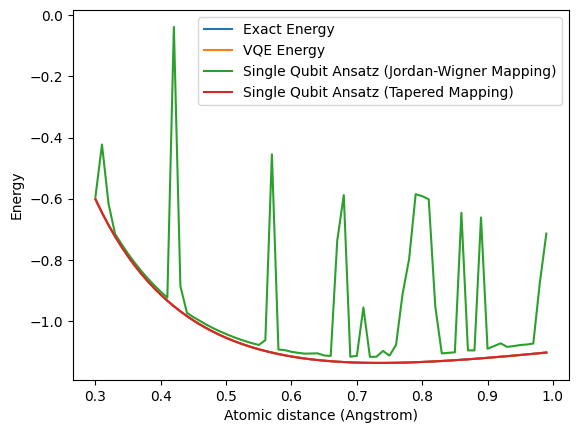

In [12]:
plt.plot(distances, exact_energies_jw, label="Exact Energy")
plt.plot(distances, vqe_energies_jw, label="VQE Energy")
plt.plot(distances, vqe_energies_jwn, label="Single Qubit Ansatz (Jordan-Wigner Mapping)")
plt.plot(distances, vqe_energies_t, label="Single Qubit Ansatz (Tapered Mapping)")
#plt.plot(distances, exact_energies_n, label="Exact Electronic energies")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()